## Tarea Renta Variable - MIAX
#### Juan José Daza Linares - 07/12/2025

### Introducción

Este Notebook proporciona una resolución a la *Tarea de Renta Variable*. A lo largo de este archivo, se irán resolviendo las diferentes cuestiones planteadas, con la ayuda de los métodos auxiliares desarrollados en los archivos *src/reader.py* y *src/analyzer.py*.

### Do arbitrage opportunities still exist in Spanish equities?
Basándonos en los resultados, es poco probable, por no decir imposible, que siga existiendo. Sería necesario tener una conexión sin latencia para poder sacar beneficio.

### What is the maximum theoretical profit (assuming 0 latency)?
Asumiendo una latencia = 0, el beneficio teórico máximo es 1921.844 €, haciendo arbitraje con todos los ISIN facilitados

### The "Latency Decay" Curve: How quickly does this profit vanish as our trading system gets slower (from 0µs to 100ms)?
Se muestra en el apartado ***The Decay Chart***


In [1]:
import reader
import analyzer
import pandas as pd
import matplotlib.pyplot as plt

### Money Table

*A summary table showing the Total Realized Profit for all processed ISINs at each latency level*

Obtenemos una lista con todos los ISIN

In [2]:
isins = reader.get_all_isins()
print(isins)

['ES0140609019', 'ES0178165017', 'ES0105634002', 'ES0105606190', 'ES0173093024', 'DE000SX0AMY5', 'GB00BDCPN049', 'BRBBDCACNPR8', 'ES0171743901', 'DE000FD1Q5F6', 'DE000FD1Q4U8', 'ES0105589008', 'DE000FD1Q4A0', 'DE000SX50XC2', 'ES0105848008', 'ES0126501131', 'ES0136463017', 'ES0172708234', 'ES0167050915', 'ES0105287009', 'ES0105857009', 'ES0114820113', 'NLBNPES1ZMK7', 'ES0121975009', 'ES0130960018', 'ES0175589029', 'NLBNPES1Q3T8', 'DE000FA5G8E7', 'ES0105621009', 'ES0105336038', 'DE000SQ6DV56', 'DE000FD1Q344', 'PEP648014202', 'FR0010251744', 'ES0118594417', 'ES0116920333', 'ES0177542018', 'ES0105102000', 'DE000FD1QYE5', 'ES0105884011', 'LU1598757687', 'DE000FA5HGL0', 'ES0105618005', 'ES0105709002', 'ES0169501022', 'NL0000235190', 'ES0105548004', 'ES0157261019', 'ES0109260531', 'AU000000BKY0', 'ES0105089009', 'ES0112501012', 'ES0105375002', 'DE000SX0AZM2', 'ES0105509006', 'ES06837469D8', 'DE000FA5HCF1', 'DE000FD1Q0E0', 'DE000FD1QS80', 'ARP125991090', 'DE000SQ6DV64', 'DE000SW92XJ1', 'DE000F

Para cada isin vamos a calcular sus arbitrajes y, posteriormente, haremos una tabla con ISIN - Beneficio - Latencia

In [9]:
latencies = [0, 100, 500, 1000, 2000, 3000, 4000, 5000, 10000, 15000, 20000, 30000, 50000, 100000]
beneficios_por_isin = pd.DataFrame(columns=[f'{l} us de Latencia' for l in latencies], index=isins)
for isin in isins:
    isin_df = reader.load_for_isin(isin)
    if isin_df is not None:
        for latency in latencies:
            arbitrages = analyzer.find_arbitrage(isin_df, latency)
            beneficios_por_isin.loc[isin, f'{latency} us de Latencia'] = arbitrages['Profit'].sum()
    else:
        print(f"WARN: No se han podido cargar datos para el ISIN {isin}")

WARN: No se han podido cargar datos para el ISIN ES0155887039
WARN: No se han podido cargar datos para el ISIN ES0110241009
WARN: No se han podido cargar datos para el ISIN ES0155734033
WARN: No se han podido cargar datos para el ISIN ES0137927135
WARN: No se han podido cargar datos para el ISIN ES0175496035


In [4]:
beneficios_totales = pd.DataFrame([beneficios_por_isin.sum()])
beneficios_totales.head()

,0 us de Lantencia,100 us de Lantencia,500 us de Lantencia,1000 us de Lantencia,2000 us de Lantencia,3000 us de Lantencia,4000 us de Lantencia,5000 us de Lantencia,10000 us de Lantencia,15000 us de Lantencia,20000 us de Lantencia,30000 us de Lantencia,50000 us de Lantencia,100000 us de Lantencia
0,1921.844,1647.437,1406.346,1092.659,792.663,563.695,336.552,-197.598,-567.222,-971.351,-1161.804,-1408.712,-1433.144,-1507.63


### The Decay Chart

*A line chart visualizing how Total Profit (Y-axis) decays as Latency (X-axis) increases*

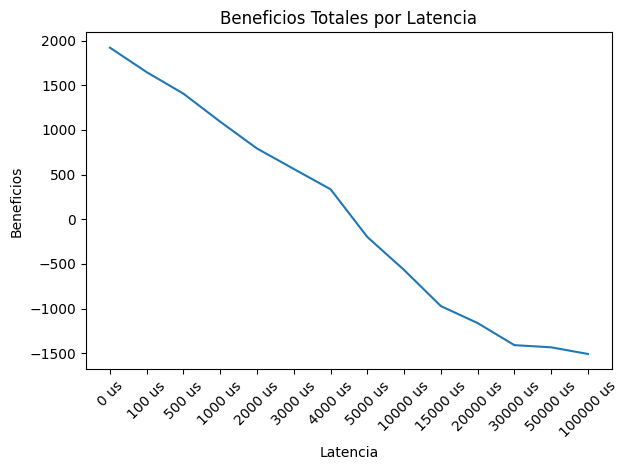

In [10]:
plt.plot([' '.join(s.split(' ')[:2]) for s in beneficios_totales.columns.values], beneficios_totales.iloc[0])
plt.xlabel("Latencia")
plt.ylabel("Beneficios")
plt.title("Beneficios Totales por Latencia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top Opportunities

*A list of the Top 5 most profitable ISINs (at 0 latency). Sanity check these results—do they look real?*

In [13]:
beneficios_por_isin['0 us de Latencia'].sort_values(ascending=False).head(5)

ES0177542018    1046.21
ES0113211835    251.845
ES0109067019      158.2
ES0113900J37    134.519
ES0182870214     62.062
Name: 0 us de Latencia, dtype: object

En general, los beneficios obtenidos son muy altos. Estos beneficios son en el supuesto de tener una latencia = 0 (ser más rápido que la velocidad de la luz), por lo que no se aproximan a la realidad.
Apreciando la curva, es posible ver una situación más cercana a la realidad; a mayor latencia, menor beneficio. Podemos observar algún repunte, pero probablemente sea casualidad. La realidad es que, **con latencias altas tenemos pérdidas**, ya que cuando vamos a ejecutar la orden, los precios y/o las cantidades han variado.

### Notas adicionales

* Se han "agrupado" las órdenes iguales, para un mismo mic, dentro de un intervalo de tiempo inferior a 1 segundo. Si alguno de los volumenes (ask o bid) cambia entre órdenes, se ha interpretado como una orden diferente (una nueva oportunidad).
* Si una oportunidad se mantiene por más de un segundo, se interpreta como múltiples nuevas oportunidades, tantas como segundos se mantenga (*if an opportunity persists for 1 second (1000 snapshots), you can only trade it once (the first time it appears)*).
